<a href="https://colab.research.google.com/github/albalopezdevesa/PROYECTO-INTEGRADOR-III/blob/main/Proyecto_Integrador_III_Predicci%C3%B3n_de_Lesividad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción de la lesividad**

In [ ]:
# Instalar imbalanced-learn
!pip install imbalanced-learn


In [ ]:
!pip install scikit-learn

In [ ]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

###**Regresión Multinomial**

Predicción utilizando RandomOverSampler con clases desbalanceadas

In [ ]:
# Cargar los datos
datos = pd.read_csv('bbdd_limpia.csv')

# Preprocesamiento de los datos
ninguna = ['Sin asistencia sanitaria','Asistencia sanitaria sólo en el lugar del accidente']
leve = ['Ingreso inferior o igual a 24 horas','Atención en urgencias sin posterior ingreso','Asistencia sanitaria inmediata en centro de salud o mutua']
grave = ['Ingreso superior a 24 horas','Asistencia sanitaria ambulatoria con posterioridad','Fallecido 24 horas']

datos['lesividad'] = datos['lesividad'].replace(ninguna, 'ninguna')
datos['lesividad'] = datos['lesividad'].replace(leve, 'leve')
datos['lesividad'] = datos['lesividad'].replace(grave, 'grave')

datos = datos.dropna()
datos = datos[datos['lesividad'] != 'Se desconoce']

# Dividir los datos en características (X) y variable objetivo (y)
datos = datos.drop(['num_acompañantes','fecha','hora','coordenada_x_utm','coordenada_y_utm','fecha_hora'], axis=1)
X = datos.drop('lesividad', axis=1)
y = datos['lesividad']

# Codificar la variable objetivo 'lesividad' a valores numéricos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Calcular las frecuencias de cada clase en y_train_encoded
classes = np.unique(y_train)
class_counts = np.bincount(y_train)

# Calcular los pesos de clase inversamente proporcionales a las frecuencias
total_samples = len(y_train)
class_weights = total_samples / (len(classes) * class_counts)

# Crear un diccionario de pesos de clase para usar en el modelo
class_weight = {i: class_weights[i] for i in range(len(classes))}

# Definir las transformaciones para las variables categóricas
categorical_features = ['tipo_vehiculo', 'sexo', 'positiva_alcohol', 'positiva_droga', 'distrito', 'hora_categoria', 'dia', 'festivo', 'rango_edad', 'estado_meteorológico']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar las transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear un RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Aplicar el RandomOverSampler a los datos de entrenamiento
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Calcular las frecuencias de cada clase en y_train_resampled
class_counts_resampled = np.bincount(y_train_resampled)

# Calcular los pesos de clase inversamente proporcionales a las frecuencias
total_samples_resampled = len(y_train_resampled)
class_weights_resampled = total_samples_resampled / (len(classes) * class_counts_resampled)

# Crear un diccionario de pesos de clase para usar en el modelo
class_weight_resampled = {i: class_weights_resampled[i] for i in range(len(classes))}

# Definir el modelo de regresión logística multinomial con pesos de clase
model_resampled = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight=class_weight_resampled))])

# Entrenar el modelo con los datos resampleados
model_resampled.fit(X_train_resampled, y_train_resampled)

# Predecir sobre el conjunto de prueba
y_pred_resampled = model_resampled.predict(X_test)

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred_resampled))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.15      0.52      0.23       953
           1       0.39      0.37      0.38      3436
           2       0.92      0.79      0.85     15147

    accuracy                           0.70     19536
   macro avg       0.49      0.56      0.49     19536
weighted avg       0.79      0.70      0.74     19536



Vemos que predice muy bien la clase con más registros pero no las otras dos que tienen menos registros. Está afectando mucho el desbalanceo.

In [ ]:
# Cargar los datos
data = pd.read_csv('bbdd_limpia.csv')

In [ ]:
data = data.dropna()

In [ ]:
# Mapear categorías a valores más generales
mapeo_lesividad = {
    'Sin asistencia sanitaria': 'ninguna',
    'Asistencia sanitaria sólo en el lugar del accidente': 'ninguna',
    'Ingreso inferior o igual a 24 horas': 'leve',
    'Atención en urgencias sin posterior ingreso': 'leve',
    'Asistencia sanitaria inmediata en centro de salud o mutua': 'leve',
    'Ingreso superior a 24 horas': 'grave',
    'Asistencia sanitaria ambulatoria con posterioridad': 'grave',
    'Fallecido 24 horas': 'grave'
}

data['lesividad'] = data['lesividad'].map(mapeo_lesividad)

# Eliminar registros 'Se desconoce'
data = data[data['lesividad'] != 'Se desconoce']

# Eliminar columnas no deseadas
data = data.drop(['num_acompañantes','tipo_persona', 'fecha', 'hora', 'coordenada_x_utm', 'coordenada_y_utm', 'fecha_hora', 'dia'], axis=1)



<ipython-input-71-ab36592be232>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lesividad'] = data['lesividad'].map(mapeo_lesividad)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97686 entries, 7 to 183007
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distrito              97686 non-null  object 
 1   estado_meteorológico  97686 non-null  object 
 2   tipo_vehiculo         97686 non-null  object 
 3   rango_edad            97686 non-null  object 
 4   sexo                  97686 non-null  object 
 5   lesividad             97677 non-null  object 
 6   positiva_alcohol      97686 non-null  object 
 7   positiva_droga        97686 non-null  float64
 8   hora_categoria        97686 non-null  object 
 9   num_dia_semana        97686 non-null  int64  
 10  festivo               97686 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 8.9+ MB


In [ ]:
print(data['lesividad'].unique())

['ninguna' 'leve' 'grave' nan]


In [ ]:
data = data[(data['sexo'] != 'Desconocido') &
              (data['rango_edad'] != 'Desconocido') &
              (data['tipo_vehiculo'] != 'Desconocido')]

In [ ]:
# Eliminar los valores NaN de la variable 'lesividad'
data = data.dropna(subset=['lesividad'])

# Imprimir los nombres de las categorías de 'lesividad'
print(data['lesividad'].unique())


['ninguna' 'leve' 'grave']


Vamos a probar a predecir la lesividad con otro enfoque. Se utiliza RandomUnderSampler.

In [ ]:
# Copiar el DataFrame original para mantener una copia sin modificar
datos_encoded = datos.copy()

# Obtener todas las columnas categóricas excepto 'lesividad'
columnas_categoricas = datos_encoded.select_dtypes(include=['object']).columns.tolist()

# Iterar sobre cada columna categórica y aplicar LabelEncoder
label_encoders = {}
for columna in columnas_categoricas:
    label_encoder = LabelEncoder()
    datos_encoded[columna] = label_encoder.fit_transform(datos_encoded[columna])
    label_encoders[columna] = label_encoder


In [ ]:
datos_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97677 entries, 7 to 183007
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distrito              97677 non-null  int64  
 1   estado_meteorológico  97677 non-null  int64  
 2   tipo_vehiculo         97677 non-null  int64  
 3   tipo_persona          97677 non-null  int64  
 4   rango_edad            97677 non-null  int64  
 5   sexo                  97677 non-null  int64  
 6   lesividad             97677 non-null  int64  
 7   positiva_alcohol      97677 non-null  int64  
 8   positiva_droga        97677 non-null  float64
 9   hora_categoria        97677 non-null  int64  
 10  num_dia_semana        97677 non-null  int64  
 11  dia                   97677 non-null  int64  
 12  festivo               97677 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 10.4 MB


In [ ]:
# Separar las características (X) y la variable objetivo (y)
X = datos_encoded.drop('lesividad', axis=1)
y = datos_encoded['lesividad']


In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un pipeline que combine SMOTE y RandomUnderSampler
pipeline = Pipeline([
    ('over', SMOTE(random_state=42)),
    ('under', RandomUnderSampler(random_state=42))
])

# Aplicar el pipeline al conjunto de entrenamiento
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Definir el modelo de regresión logística multinomial
model_resampled = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Entrenar el modelo con los datos resampleados
model_resampled.fit(X_train_resampled, y_train_resampled)

# Predecir sobre el conjunto de prueba
y_pred_resampled = model_resampled.predict(X_test)

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred_resampled))

              precision    recall  f1-score   support

           0       0.11      0.48      0.18       953
           1       0.29      0.25      0.27      3436
           2       0.87      0.73      0.79     15147

    accuracy                           0.63     19536
   macro avg       0.43      0.49      0.42     19536
weighted avg       0.74      0.63      0.67     19536



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Vemos que la regresión multinomial con RandomUnderSampler da pésimos resultados.

### **Balanceo de clases con SMOTE**

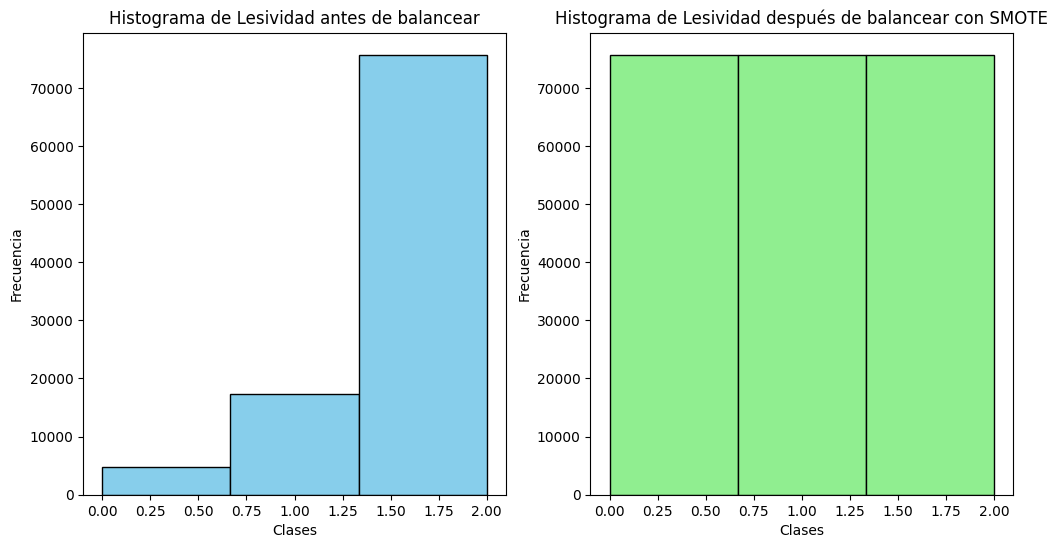

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
# Crear un SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE a los datos de entrenamiento
X_resampled, y_resampled = smote.fit_resample(X, y)

# Plotting
plt.figure(figsize=(12, 6))

# Histograma antes de balancear
plt.subplot(1, 2, 1)
plt.hist(y, bins=len(np.unique(y)), color='skyblue', edgecolor='black')
plt.title('Histograma de Lesividad antes de balancear')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')

# Histograma después de balancear con SMOTE
plt.subplot(1, 2, 2)
plt.hist(y_resampled, bins=len(np.unique(y_resampled)), color='lightgreen', edgecolor='black')
plt.title('Histograma de Lesividad después de balancear con SMOTE')
plt.xlabel('Clases')
plt.ylabel('Frecuencia')


# Guardar la gráfica como imagen
plt.savefig('smote.png')
plt.show()

# Descargar la imagen en Google Colab
from google.colab import files
files.download('smote.png')



In [ ]:
print(y_resampled.value_counts())

lesividad
2    75708
1    75708
0    75708
Name: count, dtype: int64


### **Predicción con Random Forest**


Informe de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85     15093
           1       0.73      0.76      0.75     15164
           2       0.79      0.69      0.74     15168

    accuracy                           0.78     45425
   macro avg       0.78      0.78      0.78     45425
weighted avg       0.78      0.78      0.78     45425



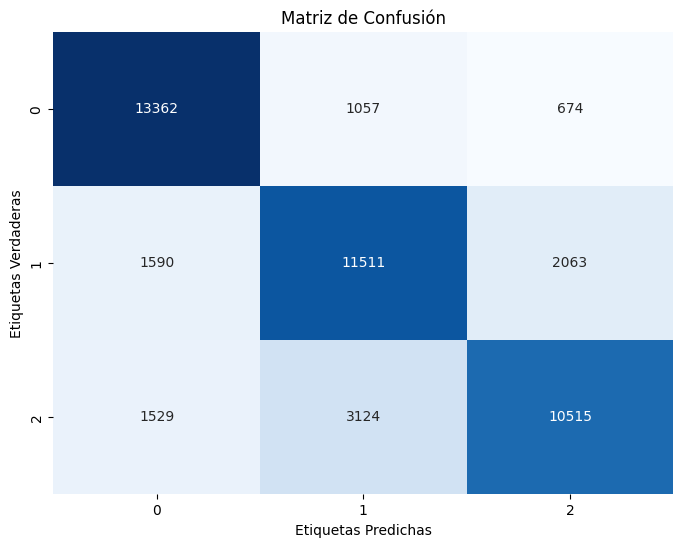

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Importar librerías
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
modelo_rf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predicciones = modelo_rf.predict(X_test)


print("\nInforme de clasificación:")
print(classification_report(y_test, predicciones))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, predicciones)

# Crear un heatmap de seaborn para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusión")
plt.xlabel("Etiquetas Predichas")
plt.ylabel("Etiquetas Verdaderas")

# Guardar la gráfica como imagen
plt.savefig('matriz_confusion.png')
plt.show()

# Descargar la imagen en Google Colab
from google.colab import files
files.download('matriz_confusion.png')
